In [242]:
import re
import numpy as np
import pandas as pd
import glob
import os
import string
import itertools
import unidecode
from functools import reduce
import json
from pandas.io.json import json_normalize
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras import optimizers, metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [313]:
files = glob.glob("csvFiles/*.csv")
df_dict = {}
for file in files:
    keyf = file.split('.')[0]
    key = keyf.split('/')[1]
    df = pd.read_csv(file)
    df.rename(columns={'Adj Close': key}, inplace=True)
    df[key].replace({'-': None},inplace =True)
    df['Date'] =  pd.to_datetime(df['Date'])
    df = df[['Date',key]]
    df[key] = df[key].astype(float)
    df[key] = df[key].interpolate()
    df_dict[key] = df

with open('csvFiles/usdreal.json') as f:
    data = json.load(f)
    df = pd.json_normalize(data, record_path=['value']) 
    df.rename(columns={'dataHoraCotacao': 'Date'}, inplace=True)
    df.rename(columns={'cotacaoVenda': 'usdreal'}, inplace=True)
    df['Date'] =  pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.normalize()
    df = df[['Date','usdreal']]
df_dict['usdreal'] = df

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), df_dict.values())
df_merged = df_merged.sort_values(by='Date', ascending=True)
df_merged.set_index('Date', inplace=True)
#df_merged.tail(5)
df_merged.shape

(3774, 19)

In [314]:
df_merged = df_merged[['bovespa', 'india', 'newyork', 'japan', 'usdchy', 'tnx', 'irx', 'usdgold',
       'usdinr', 'euronext', 'shangai', 'nasdac', 'hongkong', 'usdjpy',
       'london', 'chicago', 'crudeoil', 'usdeuro', 'usdreal']] 

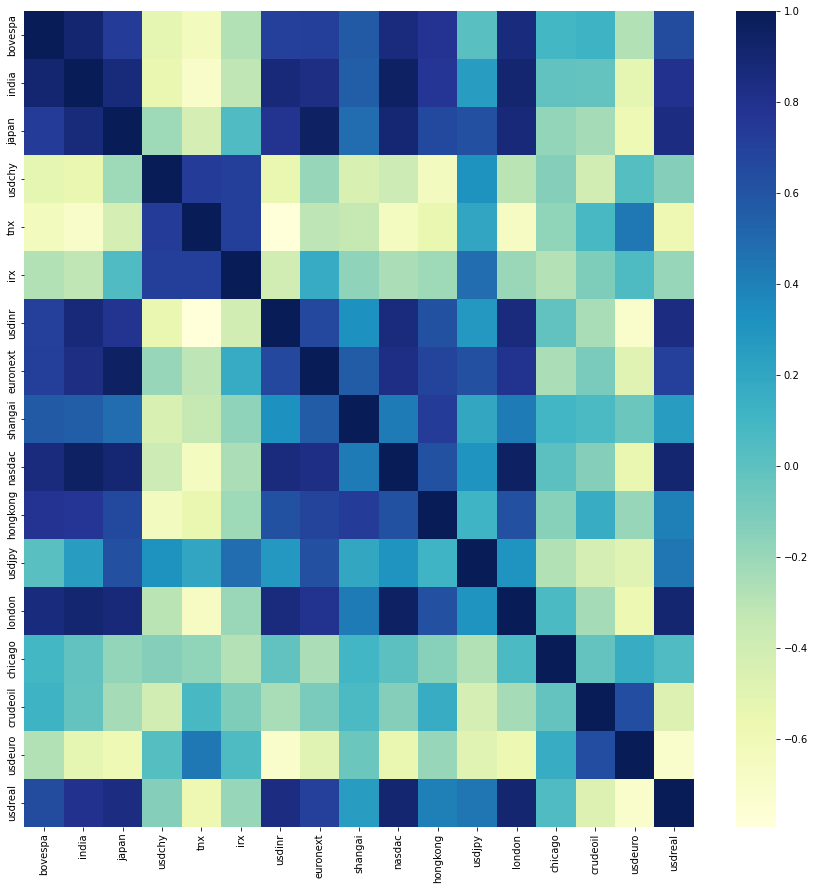

In [277]:
# Heatmap
fig, ax = plt.subplots(figsize=(15,15))  
corr = df_merged.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu");


In [315]:
len_ = int(0.85*df_merged.shape[0])
df_train = df_merged[:len_]
df_test = df_merged[len_:]
columns = df_merged.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)
df_train.head()

,bovespa,india,newyork,japan,usdchy,tnx,irx,usdgold,usdinr,euronext,shangai,nasdac,hongkong,usdjpy,london,chicago,crudeoil,usdeuro,usdreal
0,0.033068,0.018335,0.206600,0.194695,0.995858,0.779495,0.177311,0.988061,0.186312,0.250544,0.082905,0.103388,0.067700,0.670088,0.001841,0.107586,0.028634,0.281293,0.526086
1,0.032354,0.019040,0.205769,0.195099,0.995858,0.776404,0.181277,0.984840,0.184030,0.247562,0.083419,0.101990,0.065665,0.661268,0.001720,0.100536,0.035624,0.303438,0.523530
2,0.033283,0.020042,0.206109,0.190183,0.995813,0.784132,0.180286,0.977449,0.181805,0.253207,0.085331,0.099148,0.063344,0.652649,0.008588,0.105612,0.038319,0.309514,0.525147
3,0.031855,0.020154,0.207305,0.196263,0.995769,0.773570,0.178104,0.972522,0.181749,0.251472,0.086862,0.100374,0.062502,0.652048,0.002073,0.100959,0.039666,0.302004,0.528417
4,0.037137,0.017520,0.203970,0.192946,0.995724,0.733900,0.176914,0.973470,0.178961,0.242692,0.086530,0.095933,0.061233,0.639019,0.001616,0.112098,0.035203,0.320943,0.528229


In [316]:
sequence=5
stock_data_len = df_train['bovespa'].count()
X_train = []
y_train = []
for i in range(sequence, stock_data_len):
    X_train.append(df_train_ordered.iloc[i-sequence:i, 0:])
    y_train.append(df_train_ordered.iloc[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)

stock_data_len = df_test['bovespa'].count()
X_test = []
y_test = []
for i in range(sequence, stock_data_len):
    X_test.append(df_test_ordered.iloc[i-sequence:i, 0:])
    y_test.append(df_test_ordered.iloc[i, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)

#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [317]:
X_train.shape, X_test.shape

((3202, 5, 19), (562, 5, 19))

In [318]:
X_train.shape[1]

5

In [319]:
def init_model():
    metric = metrics.MAPE
    opt = optimizers.Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(GRU(64, activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(32, activation='tanh',return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [320]:
model = init_model()
#model.summary()

In [326]:
%%time
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 62.
Epoch 00082: early stopping
CPU times: user 38.5 s, sys: 3.36 s, total: 41.9 s
Wall time: 19.6 s


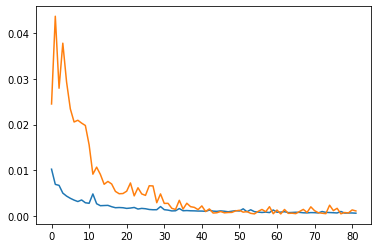

In [327]:
import matplotlib.pyplot as plt
#plt.plot(history.history['mean_absolute_percentage_error'])
#plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [328]:
res = model.evaluate(X_test, y_test, verbose=0)
res

[0.00039771408773958683, 105.90817260742188]

In [329]:
y_pred = model.predict(X_test)
y_pred.shape, y_test.shape

((562, 1), (562,))

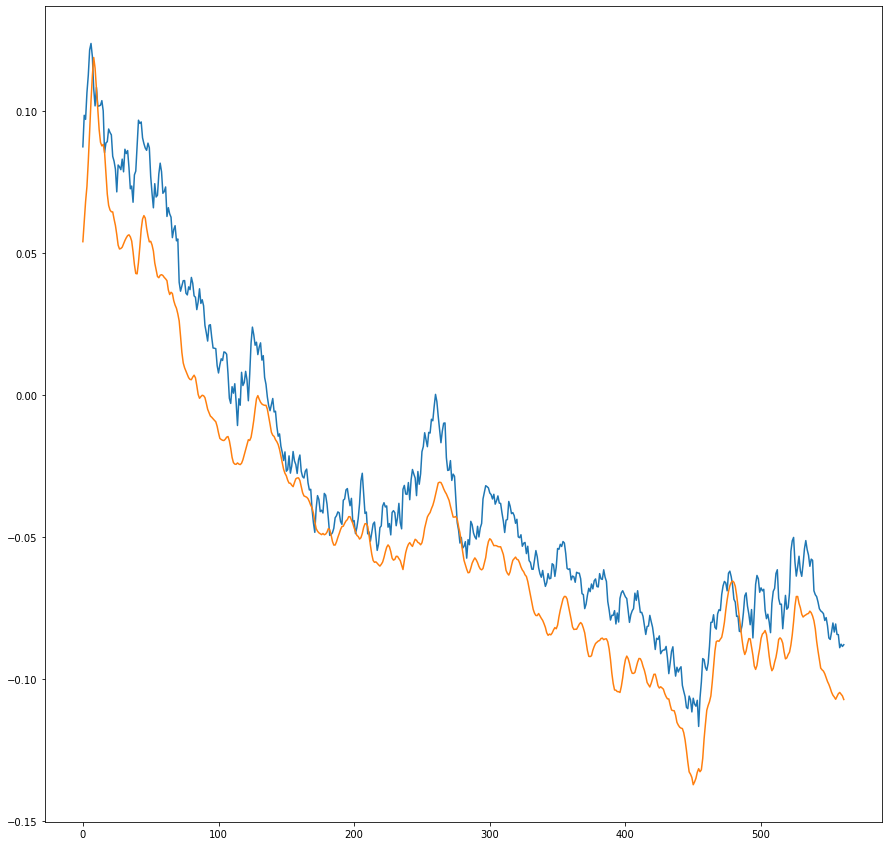

In [330]:
fig, ax = plt.subplots(figsize=(15,15))  
plt.plot(y_test)
plt.plot(y_pred)

